In [185]:
# Source: https://github.com/bnsreenu/python_for_microscopists/blob/master/263_Object%20localization%20in%20images%E2%80%8B_using_GAP_layer/263_Object%20localization%20in%20images%E2%80%8B_using_GAP_layer.py
import sys
import numpy as np
import scipy   #to upscale the image
import matplotlib.pyplot as plt
import cv2     
from google.colab.patches import cv2_imshow
from PIL import Image

In [186]:
# One of the following options:
# ResNet50, VGG19, InceptionV3, EfficientNetB0, EfficientNetB1, EfficientNetB6, squeezenet
model_name = 'InceptionV3'
debug = False

In [187]:
from keras.models import Model

if model_name == 'ResNet50':
  from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
elif model_name == 'VGG19':
  from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions
elif model_name == 'InceptionV3':
  from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
elif model_name == 'EfficientNetB0':
  from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input, decode_predictions
elif model_name == 'EfficientNetB1':
  from tensorflow.keras.applications.efficientnet import EfficientNetB1, preprocess_input, decode_predictions
elif model_name == 'EfficientNetB6':
  from tensorflow.keras.applications.efficientnet import EfficientNetB6, preprocess_input, decode_predictions
elif model_name == 'squeezenet':
  import torchvision
  from torchvision.models import squeezenet1_1
  from torchvision.models.feature_extraction import create_feature_extractor
else:
  print('Model is not supported!')
  sys.exit()

In [188]:
# Default for ResNet, VGG19, squeezenet
input_size = 224
input_dim = (224,224)
feats = 0

if model_name == 'ResNet50':
  feats = 2048
  model = ResNet50(weights='imagenet')
elif model_name == 'VGG19':
  input_size = 224
  input_dim = (224,224)
  feats = 512
  model = VGG19(weights='imagenet')
elif model_name == 'InceptionV3':
  input_size = 296
  input_dim = (299,299)
  feats = 2048
  model = InceptionV3(weights='imagenet')
elif model_name == 'EfficientNetB0':
  feats = 1280
  model = EfficientNetB0(weights='imagenet')
elif model_name == 'EfficientNetB1':
  input_size = 240
  input_dim = (240,240)
  feats = 1280
  model = EfficientNetB1(weights='imagenet')
elif model_name == 'EfficientNetB6':
  input_size = 527
  input_dim = (528,528)
  feats = 2304
  model = EfficientNetB6(weights='imagenet')
elif model_name == 'squeezenet':
  feats = 86528
  model = squeezenet1_1(pretrained=True)
else:
  print('Model is not supported!')
  sys.exit()

if debug:
  print(model.summary()) #Notice the Global Average Pooling layer at the last but onemodel = VGG19(weights='imagenet')

In [189]:
feat_layer = 0
last_layer_weights = 0

# Get weights for the prediction layer (last layer)
if model_name != 'squeezenet':
  last_layer_weights = model.layers[-1].get_weights()[0]  #Predictions layer


if model_name == 'ResNet50':
  feat_layer = -3
elif model_name == 'VGG19':
  feat_layer = -6
elif model_name == 'InceptionV3':
  feat_layer = -3
elif model_name == 'EfficientNetB0':
  feat_layer = -4
elif model_name == 'EfficientNetB1':
  feat_layer = -4
elif model_name == 'EfficientNetB6':
  feat_layer = -4
elif model_name == 'squeezenet':
  return_nodes = { 'features.12.cat': 'layer12' }
  model = create_feature_extractor(model, return_nodes=return_nodes)
else:
  print('Model is not supported!')
  sys.exit()

# For keras models: Output both predictions (last layer) and conv5_block3_add (just before final activation layer)
if model_name != 'squeezenet':
  transfer_model = Model(inputs=model.input, outputs=(model.layers[feat_layer].output, model.layers[-1].output)) 

In [190]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [191]:
def get_heatmap(input_img):
    img_tensor = np.expand_dims(input_img, axis=0)

    preprocessed_img = preprocess_input(img_tensor)

    #Get the predictions and the output of last conv. layer. 
    last_conv_output, pred_vec = transfer_model.predict(preprocessed_img)
    
    print('last_conv_output',last_conv_output.shape)
    #Last conv. output for the image
    last_conv_output = np.squeeze(last_conv_output) # usually 7x7xfeats
    #Prediction for the image
    pred = np.argmax(pred_vec)
    
    decode_predictions(pred_vec, top=1)
    
    # spline interpolation to resize each filtered image to size of original image 
    h = int(input_img.shape[0]/last_conv_output.shape[0])
    w = int(input_img.shape[1]/last_conv_output.shape[1])
    upsampled_last_conv_output = scipy.ndimage.zoom(last_conv_output, (h, w, 1), order=1) # dim: imput_size x imput_size x feats
    print('upsampled_last_conv_output',upsampled_last_conv_output.shape)

    #Get the weights from the last layer for the prediction class
    last_layer_weights_for_pred = last_layer_weights[:, pred] # dim: (2048,) 
    print('last_layer_weights_for_pred',last_layer_weights_for_pred.shape)
    
    #To generate the final heat map. 
    #Reshape the upsampled last conv. output to n x filters and multiply (dot product) 
    # with the last layer weigths for the prediction. 
    # Reshape back to the image size for easy overlay onto the original image. 
    heat_map = np.dot(upsampled_last_conv_output.reshape((input_size*input_size, feats)), 
                  last_layer_weights_for_pred).reshape(input_size,input_size)
    return heat_map

In [192]:
fname = 'drive/MyDrive/SLR_test/Video/Cam2/3/2022-04-19 15-46-15.mp4'

sample = cv2.VideoCapture(fname)

In [193]:
def play_video_format(video_data):
    # Read until video is completed
    i = 0
    while (video_data.isOpened()):
        # Capture frame-by-frame
        ret, frame = video_data.read()
        if ret == True:
          i += 1
          if i < 125:
            continue
          img = Image.fromarray(frame, 'RGB')
          img = img.resize(input_dim)
          img = np.array(img)
          cv2_imshow(img)

          # Display the resulting frame
          heat_map = get_heatmap(img)
          fig, ax = plt.subplots()
          ax.imshow(img)
          ax.imshow(heat_map, cmap='jet', alpha=0.5)
          plt.show()
          break

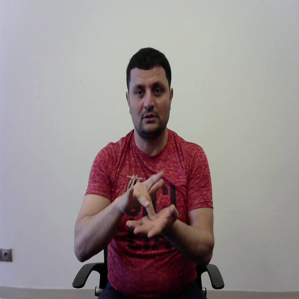

1/1 [==============================] - 2s 2s/step
last_conv_output (1, 8, 8, 2048)
upsampled_last_conv_output (296, 296, 2048)
last_layer_weights_for_pred (2048,)


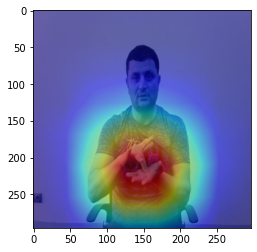

In [194]:
play_video_format(sample)